<a href="https://colab.research.google.com/github/misiupysiu/Artificial-Intelligence/blob/master/Lateral_inhibition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# After imports you should restart runtime to use newly installed libraries.

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\10/'    
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
version='1.1.0'

print(accelerator)
print(platform)
print(cuda_output)

!pip3 install https://github.com/albu/albumentations/archive/0.2.0.tar.gz albumentations
!pip3 install -U -I https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl
!pip3 install -I https://download.pytorch.org/whl/{accelerator}/torch-{version}-{platform}-linux_x86_64.whl
!pip3 install --no-cache-dir -I pillow

cu100
cp36-cp36m
['cu100', '\tlibcudart.so (libc6,x86-64) => /usr/local/cuda-10.0/targets/x86_64-linux/lib/libcudart.so']
     - 36.1MB 29.1MB/s
     |████████████████████████████████| 634kB 3.5MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=76527d812b7e20487cb7cb751ab0113ec56f40c5a18fc185ccd4ea72bec73306
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 2.6MB 942kB/s 
     |████████████████████████████████| 20.0MB 437kB/s 
     |████████████████████████████████| 2.1MB 25.4MB/s 
     |████████████████████████████████| 773.1MB 24kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


     |████████████████████████████████| 770.7MB 23kB/s 
  Using cached https://files.pythonhosted.org/packages/0e/46/ae6773894f7eacf53308086287897ec568eac9768918d913d5b9d366c5db/numpy-1.17.3-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 1.1.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


     |████████████████████████████████| 2.1MB 3.5MB/s 


In [7]:
# Common imports

%matplotlib inline

import torch

print(torch.__version__)
print(torch.cuda.is_available())

1.3.1
True


In [0]:
import collections
import os
import re

import numpy as np
import scipy.io
import scipy.ndimage
import matplotlib.pyplot as plt

import PIL

import logging
logging.getLogger("PIL").setLevel(logging.INFO)

from torch import nn
import torch.nn.functional as F
import torchvision

import seaborn as sns
sns.set_style('white')

In [0]:
CUDA = torch.cuda.is_available()

def to_np(x):
    return x.detach().cpu().numpy()

def to_tensor(x, **kwargs):
    device = 'cuda' if CUDA else 'cpu'
    return torch.tensor(x, device=device, **kwargs)

In [10]:
![ -e ilsvrc_subsample.tar.bz2 ] || gdown 'https://drive.google.com/uc?id=1Y9xfTe9rjvFiX5N9DZqCRm83zHtQUBDC' -O ilsvrc_subsample.tar.bz2

Downloading...
From: https://drive.google.com/uc?id=1Y9xfTe9rjvFiX5N9DZqCRm83zHtQUBDC
To: /content/ilsvrc_subsample.tar.bz2
25.5MB [00:00, 61.6MB/s]


In [0]:
![ -d ilsvrc_subsample ] || tar jxf ilsvrc_subsample.tar.bz2

In [0]:
class ILSVRC2014Sample:
    """Mapper from numerical class IDs to their string LABELS and DESCRIPTIONS.
    
    Please use the dicts:
    - id_to_label and label_to_id to convert string labels and numerical ids
    - label_to_desc to get a textual description of a class label
    - id_to_desc to directly get descriptions for numerical IDs
    
    """
    def __init__(self, num=100):
        self.transforms = [
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224)]
        
        base_dir = 'ilsvrc_subsample'
        devkit_dir = base_dir
        
        meta = scipy.io.loadmat(devkit_dir + '/meta.mat')
        imagenet_class_names = []
        self.label_to_desc = {}
        for i in range(1000):
            self.label_to_desc[meta['synsets'][i][0][1][0]] = meta['synsets'][i][0][2][0]
            imagenet_class_names.append(meta['synsets'][i][0][1][0])
        
        img_names = sorted(os.listdir(base_dir + '/img'))[:num]
        print(len(img_names))
        img_ids = {int(re.search('\d{8}', name).group()) for name in img_names}
        with open(devkit_dir + '/ILSVRC2012_validation_ground_truth.txt', 'r') as f:
            self.labels = [imagenet_class_names[int(line.strip()) - 1] \
                           for i, line in enumerate(f) if i+1 in img_ids]
        self.data = [self.load_image(base_dir + '/img/' + name)
                     for name in img_names]
        
        self.id_to_label = sorted(self.label_to_desc.keys())
        self.label_to_id = {}
        self.id_to_desc = []
        for id_, label in enumerate(self.id_to_label):
            self.label_to_id[label] = id_
            self.id_to_desc.append(self.label_to_desc[label])
            
    
    def load_image(self, path):
        img = PIL.Image.open(path)
        img = img.convert('RGB')
        for t in self.transforms:
            img = t(img)
        return np.asarray(img).astype('float32') / 255.0

In [37]:
class VGGPreprocess(torch.nn.Module):
    """Pytorch module that normalizes data for a VGG network
    """
    # These values are taken from http://pytorch.org/docs/master/torchvision/models.html
    RGB_MEANS = torch.FloatTensor([0.485, 0.456, 0.406])[None, :, None, None]
    RGB_STDS = torch.FloatTensor([0.229, 0.224, 0.225])[None, :, None, None]
    
    def forward(self, x):
        """Normalize a single image or a batch of images
        
        Args:
            x: tensor containing and float32 RGB image tensor with 
              dimensions (batch_size x width x heigth x RGB_channels) or 
              (width x heigth x RGB_channels).
        Returns:
            tensor containing a normalized BGR image with shape 
              (batch_size x BGR_channels x width x heigth)
        """
        if x.dim() == 3:
            x = torch.unsqueeze(x, 0)
        # x is batch * width * heigth *channels,  
        # make it batch * channels * width * heigth 
        if x.size(3) == 3:
            x = x.permute(0, 3, 1, 2)
        means = self.RGB_MEANS
        stds = self.RGB_STDS
        if x.is_cuda:
            means = means.cuda()
            stds = stds.cuda()
        x = (x - means) / stds
        return x


class VGG(torch.nn.Module):
    """
    Wrapper around a VGG network allowing convenient extraction of layer activations.
    """
    FEATURE_LAYER_NAMES = {
        'vgg16':
            ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "pool1",
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "pool2",
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3", "pool3",
             "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3", "pool4",
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3", "pool5"],
        'vgg19':
            ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "pool1",
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "pool2",
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3", "conv3_4", "relu3_4", "pool3",
             "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3", "conv4_4", "relu4_4", "pool4",
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3", "conv5_4", "relu5_4", "pool5"]}
    
    def __init__(self, model='vgg19'):
        super(VGG, self).__init__()
        all_models = {'vgg16': torchvision.models.vgg16,
                      'vgg19': torchvision.models.vgg19}   
        vgg = all_models[model](pretrained=True)
        
        self.preprocess = VGGPreprocess()
        self.features = vgg.features
        self.classifier = vgg.classifier
        self.softmax = torch.nn.Softmax(dim=-1)
        
        self.feature_names = self.FEATURE_LAYER_NAMES[model]
        
        assert len(self.feature_names) == len(self.features)

    def forward(self, x):
        """ Return pre-softmax unnormalized logits. 
        """
        x = self.preprocess(x)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def logits_and_activations(self, x, layer_names, as_dict=False, suppression_masks={}, show_maps=False):
        x = self.preprocess(x)
        
        needed_layers = set(layer_names)
        if suppression_masks != {}:
            assert all(layer in suppression_masks for layer in needed_layers)
        layer_values = {}
        
        pnum = 1
        for name, layer in zip(self.feature_names, self.features):
            if name in suppression_masks:
                print(name)
                print(suppression_masks[name].size())
                print()
                if show_maps:
                    plt.subplot(len(layer_names), 3, pnum)
                    pnum += 1
                    plt.imshow(to_np(suppression_masks[name].squeeze()), cmap='viridis')
                    plt.colorbar(shrink=1.0)
                    plt.title(f"suppression mask - ${name}")

                    plt.subplot(len(layer_names), 3, pnum)
                    pnum += 1
                    plt.imshow(to_np(x.squeeze(0).sum(0)), cmap='viridis')
                    plt.colorbar(shrink=1.0)
                    plt.title(f"normal ReLu - ${name}")

                sup_mask_sized_as_x = suppression_masks[name].expand(-1, x.size()[1], -1, -1)
                x = x.where(sup_mask_sized_as_x != 0, torch.zeros_like(x))

                if show_maps:
                    plt.subplot(len(layer_names), 3, pnum)
                    pnum += 1
                    plt.imshow(to_np(x.squeeze(0).sum(0)), cmap='viridis')
                    plt.colorbar(shrink=1.0)
                    plt.title(f"inhibited ReLu - ${name}")
                
            x = layer(x)
            if name in needed_layers:
                layer_values[name] = x
        
        if not as_dict:
            layer_values = [layer_values[n] for n in layer_names]
        
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x, layer_values

    
    def probabilities(self, x):
        """Return class probabilities.
        """
        logits = self(x)
        return self.softmax(logits)
        
    def layer_activations(self, x, layer_name):
        """Return activations of a selected layer.
        """
        x = self.preprocess(x)
        for name, layer in zip(self.feature_names, self.features):
            x = layer(x)
            if name == layer_name:
                return x
        raise ValueError('Layer %s not found' % layer_name)
    
    def multi_layer_activations(self, x, layer_names):
        """Return activations of all requested layers.
        """
        x = self.preprocess(x)
        
        needed_layers = set(layer_names)
        layer_values = {}
        
        for name, layer in zip(self.feature_names, self.features):
            x = layer(x)
            if name in needed_layers:
                layer_values[name] = x
                if len(layer_values) == len(needed_layers):
                    break
        if len(layer_values) < len(needed_layers):
            raise ValueError('Layers %s not found' % (needed_layers - set(layer_values.keys())))
        
        return [layer_values[n] for n in layer_names]

    def predict(self, x):
        """Return predicted class IDs.
        """
        logits = self(x)
        _, predictions = logits.max(1)
        return predictions
    
vgg = VGG('vgg16')

if CUDA:
    vgg.cuda()
    print('VGG is working on cuda')

VGG is working on cuda


In [14]:
# List layers in the model
print('Feature layers')
print('--------------')
for name, layer in zip(vgg.feature_names, vgg.features):
    print('{1: <12} {0: <8}  ({2}'.format(name, *str(layer).split('(', 1)))
print('\nClassifier layers')
print('-----------------')
for layer in vgg.classifier:
    print('{: <12}({}'.format(*str(layer).split('(', 1)))

Feature layers
--------------
Conv2d       conv1_1   (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_1   (inplace=True)
Conv2d       conv1_2   (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_2   (inplace=True)
MaxPool2d    pool1     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv2_1   (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_1   (inplace=True)
Conv2d       conv2_2   (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_2   (inplace=True)
MaxPool2d    pool2     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv3_1   (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_1   (inplace=True)
Conv2d       conv3_2   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_2   (inplace=True)
Conv2d       conv3_3   (256, 256, kernel_size=(3, 3), stride

200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


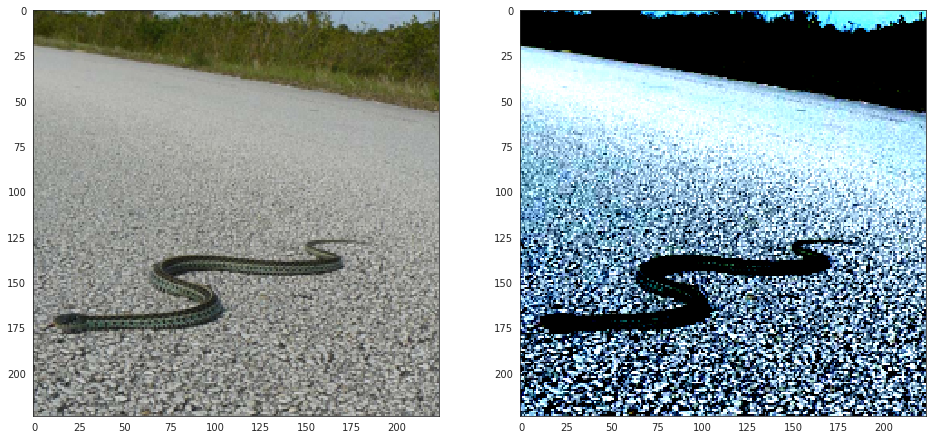

In [15]:
prep = VGGPreprocess()
ilsvrc = ILSVRC2014Sample(1000)

plt.figure(figsize=(16,16))

img = ilsvrc.data[5]
ax = plt.subplot(1,2,1)
ax.imshow(img)

new_img = to_np(prep(to_tensor(img)))
new_img = np.moveaxis(new_img, 1, 3)[0]
ax = plt.subplot(1,2,2)
ax.imshow(new_img)

200
200


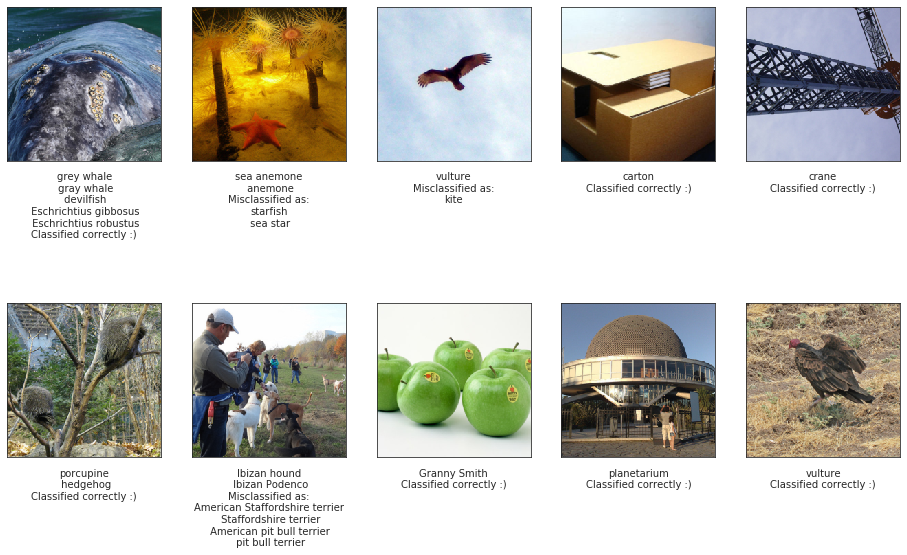

In [16]:
ilsvrc = ILSVRC2014Sample(1000)
print(len(ilsvrc.data))
vgg.eval()

offset=15

plt.figure(figsize=(16, 10))
for i in range(10):
    img = ilsvrc.data[offset + i]
    label = ilsvrc.labels[offset + i]

    img_torch = to_tensor(img)
    predicted_label_id = to_np(vgg.predict(img_torch))[0]
    predicted_label = ilsvrc.id_to_label[predicted_label_id]
    
    desc = ilsvrc.label_to_desc[label].split(',')
    if label == predicted_label:
        desc.append('Classified correctly :)')
    else:
        desc.append('Misclassified as:')
        desc.extend(ilsvrc.label_to_desc[predicted_label].split(','))
    
    ax = plt.subplot(2, 5, 1 + i)
    ax.set_xlabel('\n'.join(desc)) #, {'verticalalignment': 'bottom'})
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)
    ax.tick_params(axis='both', which='both', bottom=False, left=False, top=False)
    ax.grid(False)
    ax.imshow(img)

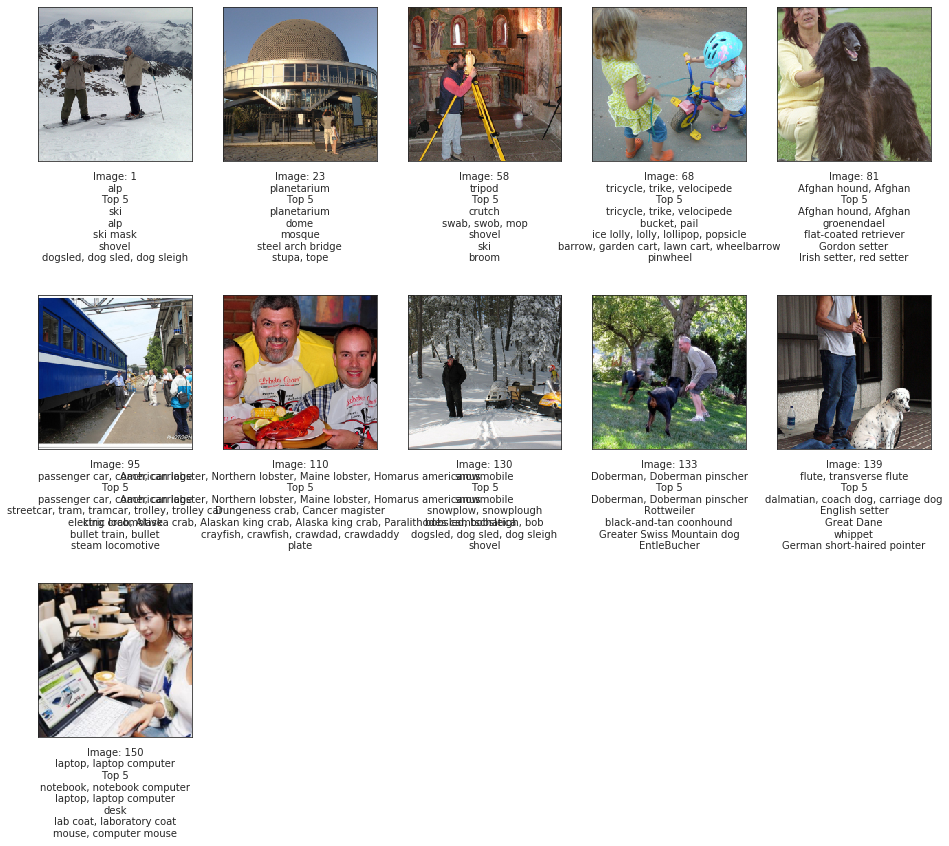

In [17]:
interesting_imgs = [
    1, 23, 58, 68, 81, 95, 110, 130, 133, 139, 150]

n_rows = (len(interesting_imgs) + 4) // 5

plt.figure(figsize=(16, n_rows * 5))
for si, i in enumerate(interesting_imgs):
    img = ilsvrc.data[i]
    label = ilsvrc.labels[i]

    img_torch = to_tensor(img)
    logits = vgg(img_torch)
    _, top5_ids = torch.topk(logits.view(-1), 5)
    predicted_label_id = top5_ids[0].item()
    predicted_label = ilsvrc.id_to_label[predicted_label_id]
    
    desc = ["Image: %d" % (i,), 
            ilsvrc.label_to_desc[label]]
    desc.append('Top 5')
    for pred in top5_ids:
        desc.append(ilsvrc.id_to_desc[pred.item()])
    
    ax = plt.subplot(n_rows, 5, 1 + si)
    ax.set_xlabel('\n'.join(desc)) #, {'verticalalignment': 'bottom'})
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)
    ax.tick_params(axis='both', which='both', bottom=False, left=False, top=False)
    ax.grid(False)
    ax.imshow(img)

Predicted: dalmatian, coach dog, carriage dog (correct: flute, transverse flute)
loss: tensor(8.7300e-08, device='cuda:0', grad_fn=<SelectBackward>)
loss: tensor(0.9224, device='cuda:0', grad_fn=<SelectBackward>)


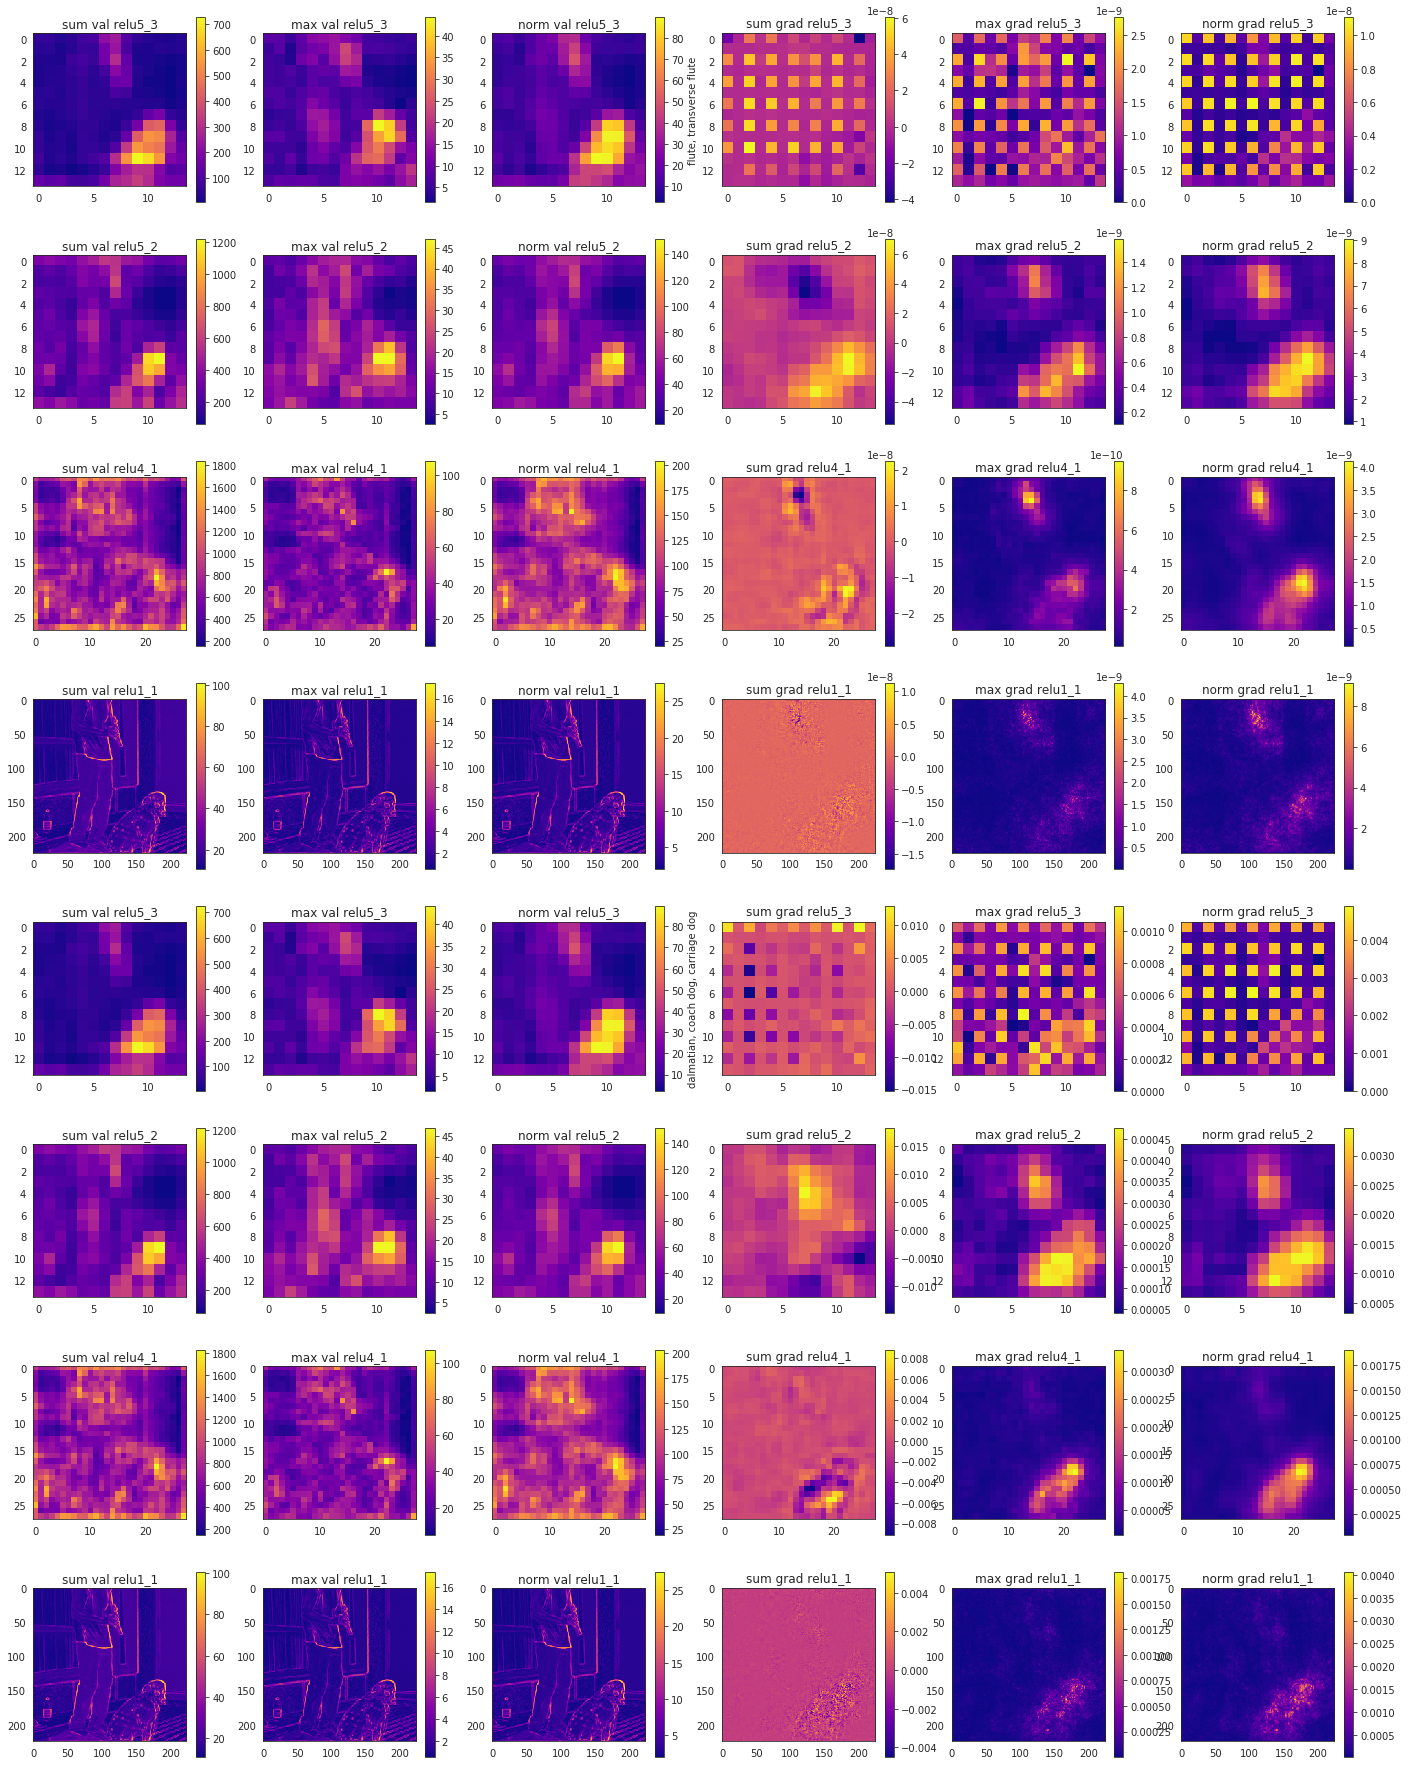

In [18]:
idx = 139
img = ilsvrc.data[idx][None, ...]
# img shape: (1, 224, 224, 3)
label = ilsvrc.labels[idx]

predicted_id = to_np(vgg.predict(to_tensor(img)))[0]

print ("Predicted: %s (correct: %s)" % (ilsvrc.id_to_desc[predicted_id],
                                        ilsvrc.label_to_desc[label]))

cats = [558,  # flute
        251]  # dalmatian
layers = ['relu5_3', 'relu5_2', 'relu4_1', 'relu1_1']

plt.figure(figsize=(24, 32))

pnum = 1
nc = len(cats)
nl = len(layers)

for cat in cats:    
    logits, acts = vgg.logits_and_activations(
        to_tensor(img), layers, as_dict=True)
    for v in acts.values():
        v.retain_grad()
    loss = F.softmax(logits, dim=-1)[0, cat]
    print('loss:', loss)
    loss.backward()
    
    for l in layers:
        plt.subplot(nl * nc, 6, pnum)
        pnum += 1
        plt.imshow(to_np(acts[l][0].sum(0)), cmap='plasma')
        plt.colorbar(shrink=1.0)
        plt.title("sum val %s" % (l, ))
    
        plt.subplot(nl * nc, 6, pnum)
        pnum += 1
        plt.imshow(to_np(acts[l][0].max(0)[0]), cmap='plasma')
        plt.colorbar(shrink=1.0)
        plt.title("max val %s" % (l, ))
    
        plt.subplot(nl * nc, 6, pnum)
        pnum += 1
        plt.imshow(to_np((acts[l][0]**2).sum(0)**0.5), cmap='plasma')
        plt.colorbar(shrink=1.0)
        plt.title("norm val %s" % (l, ))
    
        plt.subplot(nl * nc, 6, pnum)
        pnum += 1
        plt.imshow(to_np(acts[l].grad[0].sum(0)), cmap='plasma')
        plt.colorbar(shrink=1.0)
        plt.title("sum grad %s" % (l, ))
        if l == layers[0]:
            plt.ylabel(ilsvrc.id_to_desc[cat])
    
        plt.subplot(nl * nc, 6, pnum)
        pnum += 1
        plt.imshow(to_np(acts[l].grad[0].max(0)[0]), cmap='plasma')
        plt.colorbar(shrink=1.0)
        plt.title("max grad %s" % (l, ))
        
        plt.subplot(nl * nc, 6, pnum)
        pnum += 1
        plt.imshow(to_np((acts[l].grad[0]**2).sum(0)**0.5), cmap='plasma')
        plt.colorbar(shrink=1.0)
        plt.title("norm grad %s" % (l, ))


In [0]:
def mex_hat(d):
    grid = (np.mgrid[:d, :d] - d//2) * 1.0
    eucl_grid = (grid**2).sum(0) ** 0.5  # euclidean distances
    eucl_grid /= d  # normalize by LIZ length
    return eucl_grid * np.exp(-eucl_grid)  # mex_hat function values

class LateralInhibition(torch.nn.Module):
    def __init__(self, l=7, a=0.1, b=0.9):
        super().__init__()
        self.len = l
        assert self.len % 2 == 1
        self.a = a
        self.b = b
        self.register_buffer(
            'inhibition_kernel',
            to_tensor(mex_hat(l), dtype=torch.float32).view(1, 1, 1, -1))
    
    def forward(self, x): # we get (as arg) max-c map with dimensions 'batch x 1 x n x n'
        print('Lateral Inhibition forward:',x.shape)
        assert x.size(1) == 1
        assert x.size(2) == x.size(3)
        len_ = self.len
        pad = len_ // 2
        batches = x.size(0)
        n = x.size(2)
        
        # unfold x to LIZs for each pixel:
        x_unf = F.unfold(x, (len_, len_), padding=(pad, pad))
        # next line is needed for extend tensor size (from 'batch x kernel x n*n' to 'batch x 1 x kernel x n*n'):
        x_unf = x_unf.view(batches, 1, len_*len_, n*n)
        x_unf = x_unf.transpose(2,3)
        # select all middle points in LIZs:
        mid_vals = x.view(x.size(0), 1, n*n, 1)
        
        average_term = torch.exp(-x_unf.mean(3, keepdim=True)).view(batches, 1, n, n)
        
        differential_term = (self.inhibition_kernel * F.relu(x_unf - mid_vals)
                            ).sum(3, keepdim=True).view(batches, 1, n, n)
        
        suppression_mask = self.a * average_term + self.b * differential_term
        assert x.shape == suppression_mask.shape
        suppression_mask /= float(torch.max(suppression_mask))
        # because all values are non-negative we can do this:
        filter_ = x > suppression_mask
        suppression_mask = x.where(filter_, torch.zeros_like(x))
        return suppression_mask, average_term, differential_term
        
    
        # PROBLEM WITH GATING: non-normalized partial computations
        

In [20]:
ll = LateralInhibition()
ll.cuda()

# creating max-c map
max_c = acts['relu4_1'].grad.max(1, keepdim=True)[0]
# max-c map is normalized to [0,1]
m = float(torch.max(max_c))
max_c /= m


sup_mask, ave_term, dif_term = ll(max_c)

Lateral Inhibition forward: torch.Size([1, 1, 28, 28])


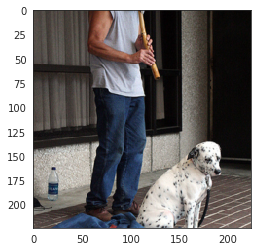

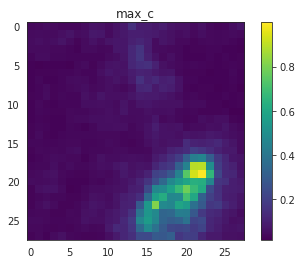

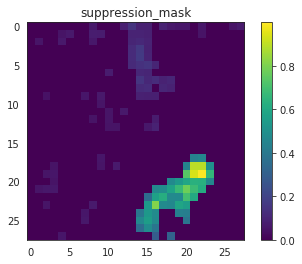

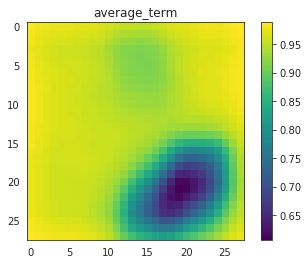

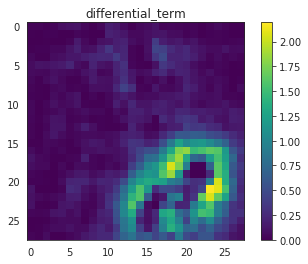

In [21]:
plt.figure()
plt.imshow(img[0])

plt.figure()
plt.imshow(to_np(max_c[0,0]), cmap='viridis'); plt.colorbar()
plt.title('max_c')

plt.figure()
plt.imshow(to_np(sup_mask[0,0]), cmap='viridis'); plt.colorbar()
plt.title('suppression_mask')

plt.figure()
plt.imshow(to_np(ave_term[0,0]), cmap='viridis'); plt.colorbar()
plt.title('average_term')

plt.figure()
plt.imshow(to_np(dif_term[0,0]), cmap='viridis'); plt.colorbar()
plt.title('differential_term');


In [0]:
# only one of the `draw` and `show_masks` flags should be set to True
class LICNN(torch.nn.Module):
    def __init__(self, vgg='vgg16', l=7, a=0.1, b=0.9, draw=False, show_masks=False):
        assert not (draw and show_masks)
        super().__init__()
        self.vgg = VGG(vgg)
        self.vgg.cuda()
        self.lateral_inhibition = LateralInhibition(l=7, a=0.1, b=0.9)
        self.lateral_inhibition.cuda()
        self.relu_layers = [name for name in self.vgg.feature_names if 'relu' in name]
        self.printable = draw
        self.show_masks=show_masks
        self.suppression_masks = {}
    
    def forward(self, img):
        # 1 & 2
        img_tensor = to_tensor(img)
        predicted_id = to_np(vgg.predict(img_tensor))[0]

        logits, acts = vgg.logits_and_activations(
            to_tensor(img), self.relu_layers, as_dict=True)
        for v in acts.values():
            v.retain_grad()
        loss = F.softmax(logits, dim=-1)[0, predicted_id]
        loss.backward()

        if self.show_masks:
            plt.figure(figsize=(24, 96))
        if self.printable:
            plt.figure(figsize=(24, 96))
            self.print_layers(acts, part=1)
        
        # 3
        for layer in self.relu_layers:
            gradient = acts[layer].grad
            # creating max-c map
            max_c = gradient.max(1, keepdim=True)[0]
            # max-c map is normalized to [0,1]
            m = float(torch.max(max_c))
            max_c /= m
            # generating suppression mask through lateral inhibition
            sup_mask, *_ = self.lateral_inhibition(max_c)
            self.suppression_masks[layer] = sup_mask

        # 4
        logits, acts = vgg.logits_and_activations(
            to_tensor(img), self.relu_layers, as_dict=True, suppression_masks=self.suppression_masks, show_maps=self.show_masks)
        for v in acts.values():
            v.retain_grad()
        loss = F.softmax(logits, dim=-1)[0, predicted_id]
        loss.backward()
        
        if self.printable:
            self.print_layers(acts, part=2)
            
    def print_layers(self, acts, part):
        def increase(pnum):
            return pnum+6+1 if pnum%6 == 0 else pnum+1
            
        pnum = (part-1)*6 + 1

        for l in self.relu_layers:
            plt.subplot(len(self.relu_layers)*2, 6, pnum)
            pnum = increase(pnum)
            plt.imshow(to_np(acts[l][0].sum(0)), cmap='plasma')
            plt.colorbar(shrink=1.0)
            plt.title("sum val %s" % (l, ))

            plt.subplot(len(self.relu_layers)*2, 6, pnum)
            pnum = increase(pnum)
            plt.imshow(to_np(acts[l][0].max(0)[0]), cmap='plasma')
            plt.colorbar(shrink=1.0)
            plt.title("max val %s" % (l, ))

            plt.subplot(len(self.relu_layers)*2, 6, pnum)
            pnum = increase(pnum)
            plt.imshow(to_np((acts[l][0]**2).sum(0)**0.5), cmap='plasma')
            plt.colorbar(shrink=1.0)
            plt.title("norm val %s" % (l, ))

            plt.subplot(len(self.relu_layers)*2, 6, pnum)
            pnum = increase(pnum)
            print('SIZE', acts[l].grad[0].size())
            plt.imshow(to_np(acts[l].grad[0].sum(0)), cmap='plasma')
            plt.colorbar(shrink=1.0)
            plt.title("sum grad %s" % (l, ))
            if l == layers[0]:
                plt.ylabel(ilsvrc.id_to_desc[predicted_id])

            plt.subplot(len(self.relu_layers)*2, 6, pnum)
            pnum = increase(pnum)
            plt.imshow(to_np(acts[l].grad[0].max(0)[0]), cmap='plasma')
            plt.colorbar(shrink=1.0)
            plt.title("max grad %s" % (l, ))

            plt.subplot(len(self.relu_layers)*2, 6, pnum)
            pnum = increase(pnum)
            plt.imshow(to_np((acts[l].grad[0]**2).sum(0)**0.5), cmap='plasma')
            plt.colorbar(shrink=1.0)
            plt.title("norm grad %s" % (l, ))

SIZE torch.Size([64, 224, 224])
SIZE torch.Size([64, 224, 224])
SIZE torch.Size([128, 112, 112])
SIZE torch.Size([128, 112, 112])
SIZE torch.Size([256, 56, 56])
SIZE torch.Size([256, 56, 56])
SIZE torch.Size([256, 56, 56])
SIZE torch.Size([512, 28, 28])
SIZE torch.Size([512, 28, 28])
SIZE torch.Size([512, 28, 28])
SIZE torch.Size([512, 14, 14])
SIZE torch.Size([512, 14, 14])
SIZE torch.Size([512, 14, 14])
Lateral Inhibition forward: torch.Size([1, 1, 224, 224])
Lateral Inhibition forward: torch.Size([1, 1, 224, 224])
Lateral Inhibition forward: torch.Size([1, 1, 112, 112])
Lateral Inhibition forward: torch.Size([1, 1, 112, 112])
Lateral Inhibition forward: torch.Size([1, 1, 56, 56])
Lateral Inhibition forward: torch.Size([1, 1, 56, 56])
Lateral Inhibition forward: torch.Size([1, 1, 56, 56])
Lateral Inhibition forward: torch.Size([1, 1, 28, 28])
Lateral Inhibition forward: torch.Size([1, 1, 28, 28])
Lateral Inhibition forward: torch.Size([1, 1, 28, 28])
Lateral Inhibition forward: torch

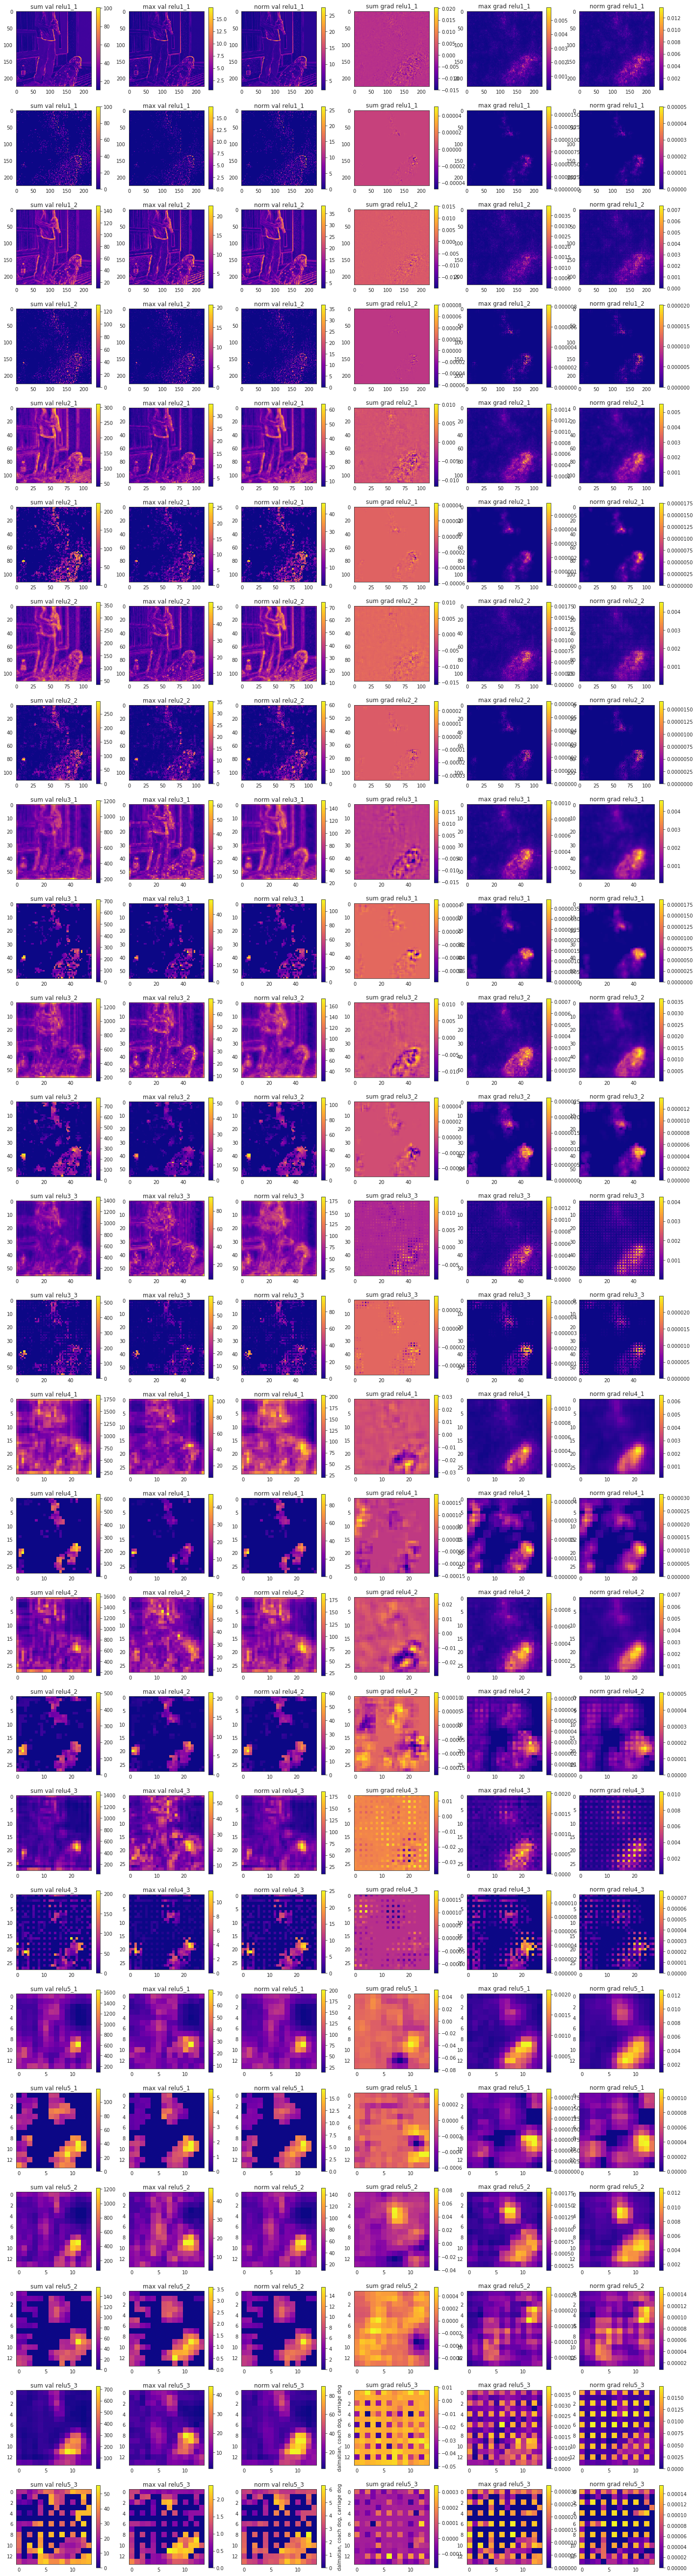

In [47]:
licnn = LICNN(draw=True, show_masks=False)
licnn(img)

In [0]:
for name, param in vgg.named_parameters():
    print(name, param.data.shape)

In [0]:
a = to_tensor([[[[1,2,3], [4,5,6], [7,8,9], [10,11,12]]]])
print(a.size())
print(a)
b = torch.ones(1,3,4,3)
print(b.size())
a.expand(-1,3,-1,-1) > 5
# acts[layer].grad = gradient.where(sup_mask != 0, acts[layer].grad)

In [0]:
a.size()


4